In [25]:
# Библиотеки для классификационного анализа эффективности IC50
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, f1_score, precision_score,
                             recall_score, confusion_matrix, roc_curve)
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Оптимизированные настройки визуализации для IC50 классификации
plt.style.use('seaborn-v0_8-pastel')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (13, 7)
plt.rcParams['font.size'] = 11

In [3]:
# Определение параметров для классификации эффективности
source_ic50_variable = 'IC50, mM'
binary_efficacy_target = 'IC50_efficacy_class'  # Новое имя для бинарной переменной

print(f"Исходная переменная: {source_ic50_variable}")
print(f"Бинарная целевая переменная: {binary_efficacy_target}")
print(f"Принцип разделения: Медианное значение IC50 как порог")
print(f"Интерпретация: Высокая/низкая эффективность соединений")

Исходная переменная: IC50, mM
Бинарная целевая переменная: IC50_efficacy_class
Принцип разделения: Медианное значение IC50 как порог
Интерпретация: Высокая/низкая эффективность соединений


In [4]:
df = pd.read_parquet("data/processed_data_full.parquet")

In [6]:
df["IC50_gt_median"] = (df[source_ic50_variable] > df[source_ic50_variable].median()).astype(int)
df

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,IC50_gt_median
0,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,6.239374,175.482382,28.125000,0
1,-2.108224,2.095440,0.951585,-0.544168,1.254983,0.289724,-1.759553,1.260180,-2.212699,-0.571135,...,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,0.771831,5.402819,7.000000,0
2,-2.514136,2.150839,0.957552,-1.490120,1.014426,0.745889,-1.118121,1.099403,-2.397328,-0.545366,...,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,223.808778,161.142320,0.720000,1
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.032191,-0.032191,-0.238522,-0.27518,3.075405,-0.085436,1.705624,107.855654,63.235294,0
4,-1.746485,0.536885,0.783714,-0.701088,0.563542,0.902106,-1.367945,2.002451,-2.242239,-0.580930,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,107.131532,139.270991,1.300000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,0.621634,-0.779389,0.307862,-0.918328,1.566453,0.492661,0.628761,-0.790557,-0.036530,-0.461498,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.000104,34.999650,1.129017,0
962,0.834722,-0.884119,0.165598,-0.980878,1.201620,1.050498,0.704502,-0.776102,-0.233468,-0.461496,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.999934,33.999415,1.062484,0
963,0.943127,-0.906571,0.196551,-1.377478,0.997433,1.522336,0.707042,-0.775993,0.065049,0.598260,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,30.999883,33.999458,1.096761,0
964,0.893994,-0.196583,-0.286468,-0.923926,0.761096,1.340989,0.586631,-0.792770,-1.593940,-0.464683,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.998959,32.999644,1.031272,0


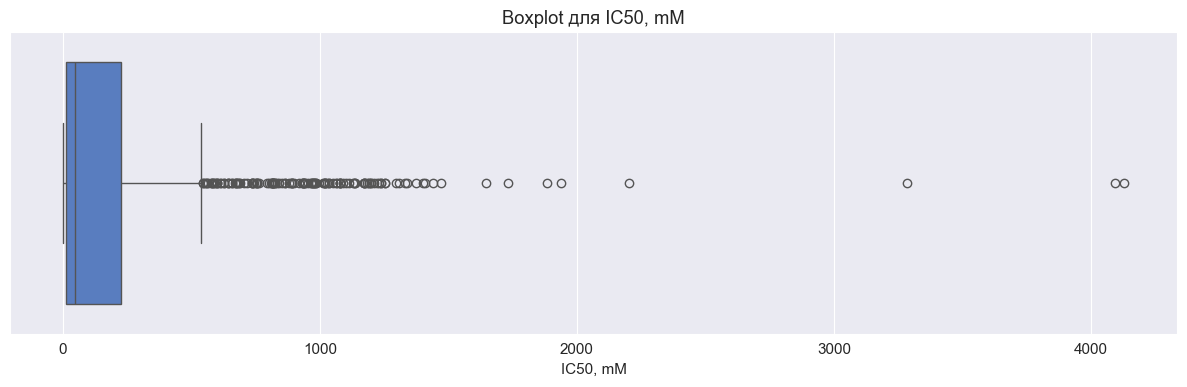

In [7]:
# Строим график для выбросов
plt.figure(figsize=(12, 4))

sns.boxplot(x=df[source_ic50_variable])

plt.title(f'Boxplot для {source_ic50_variable}')
plt.tight_layout()
plt.show()

In [9]:
mean = df[source_ic50_variable].mean()
std = df[source_ic50_variable].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

outliers = df[(df[source_ic50_variable] < lower_bound) | (df[source_ic50_variable] > upper_bound)]

print("Выбросы по правилу:")
outliers

Выбросы по правилу:


,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,IC50_gt_median
28,0.162671,-0.598151,0.036863,-0.765315,-1.485425,-0.969830,1.703837,0.676161,1.893465,0.598264,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1472.457163,2191.156492,1.488095,1
29,0.167835,-0.492682,-0.336254,-0.374021,-1.320181,-0.844268,1.703838,0.676161,1.738376,0.600354,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,4095.188563,4095.188563,1.000000,1
30,0.189542,-0.534596,0.041379,-0.600427,-1.479133,-0.859744,1.703837,0.676161,1.996858,0.598273,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,4128.529377,4128.529377,1.000000,1
31,0.194706,-0.669914,-0.311666,-0.172967,-1.323979,-0.734182,1.703838,0.676161,1.844810,0.600363,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1936.355856,1936.355856,1.000000,1
83,0.279511,-1.022494,0.606901,-0.271209,1.382454,-1.565942,-0.732016,1.457456,0.915935,-0.491791,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,2200.501846,3284.331113,1.492537,1
94,0.207366,-0.912915,0.627556,-0.271209,1.382454,-1.565942,-0.771254,1.449725,0.915935,-0.491883,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1646.106754,3284.331113,1.995211,1
95,0.279511,-1.022494,0.606901,-0.271209,1.382454,-1.565942,-0.732016,1.457456,0.915935,-0.491791,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,3284.331113,3284.331113,1.000000,1
261,0.035011,-0.238460,0.522453,-0.096957,-0.821800,-1.401328,0.642402,-0.743501,1.479895,-0.465126,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1731.961620,981.444918,0.566667,1
262,-0.035339,-0.033000,0.500323,-0.327280,-0.770623,-1.511414,0.640324,-0.783493,1.667881,-0.465719,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1884.576002,1884.576002,1.000000,1
492,0.210443,-0.312996,-2.499658,-0.170463,-1.197419,-1.087850,1.692847,0.200221,1.479895,-0.269238,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1407.406712,1407.406712,1.000000,1


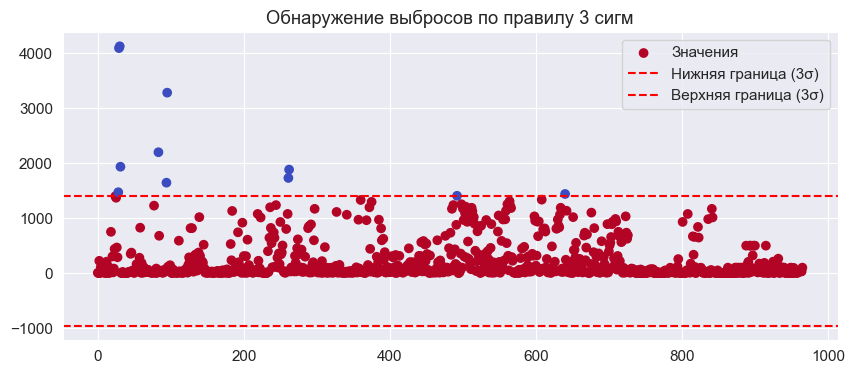

In [11]:
df['is_outlier_3σ'] = (df[source_ic50_variable] < lower_bound) | (df[source_ic50_variable] > upper_bound)

plt.figure(figsize=(10, 4))
plt.scatter(df.index, df[source_ic50_variable], c=~df['is_outlier_3σ'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (3σ)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (3σ)')
plt.legend()
plt.title('Обнаружение выбросов по правилу 3 сигм')
plt.show()

In [13]:
Q1 = df[source_ic50_variable].quantile(0.25)
Q3 = df[source_ic50_variable].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df["is_outlier_IQR"] = (df[source_ic50_variable] < lower_bound) | (df[source_ic50_variable] > upper_bound)
df[(df[source_ic50_variable] < lower_bound) | (df[source_ic50_variable] > upper_bound)]

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,IC50_gt_median,is_outlier_3σ,is_outlier_IQR
18,0.402713,-1.006219,-1.852481,0.756978,0.155856,0.370309,0.560418,-0.952232,0.525501,0.840868,...,-0.238522,-0.27518,-0.169643,-0.085436,751.968277,751.968277,1.000000,1,False,True
24,0.048712,-0.238950,0.004436,1.040143,0.354546,0.099439,-0.272623,-1.109250,-0.110761,-0.465129,...,-0.238522,-0.27518,-0.169643,-0.085436,1400.218964,1371.956657,0.979816,1,False,True
25,0.048712,-0.238950,0.004436,1.040143,0.354546,0.099439,-0.272623,-1.109250,-0.110761,-0.465129,...,-0.238522,-0.27518,-0.169643,-0.085436,1371.956657,1371.956657,1.000000,1,False,True
28,0.162671,-0.598151,0.036863,-0.765315,-1.485425,-0.969830,1.703837,0.676161,1.893465,0.598264,...,-0.238522,-0.27518,-0.169643,-0.085436,1472.457163,2191.156492,1.488095,1,True,True
29,0.167835,-0.492682,-0.336254,-0.374021,-1.320181,-0.844268,1.703838,0.676161,1.738376,0.600354,...,-0.238522,-0.27518,-0.169643,-0.085436,4095.188563,4095.188563,1.000000,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,0.804337,-0.532511,-0.588256,-1.967118,0.323978,1.905168,0.008142,-1.310958,-1.375711,-0.451067,...,-0.238522,-0.27518,-0.169643,-0.085436,840.999040,630.749280,0.750000,1,False,True
823,0.995291,-1.053041,-0.644761,-2.279578,0.509422,3.303233,0.008142,-1.307152,-1.736764,-0.450092,...,-0.238522,-0.27518,-0.169643,-0.085436,647.103436,417.381716,0.645000,1,False,True
836,0.035011,-0.238460,0.522453,-0.096957,-0.821800,-1.401328,0.642402,-0.743501,1.479895,-0.465126,...,-0.238522,-0.27518,-0.169643,-0.085436,982.674611,1734.057293,1.764630,1,False,True
841,0.100927,1.114583,0.376718,0.515427,-1.502077,-0.545230,0.768165,-1.162809,-0.587957,-0.468816,...,-0.238522,-0.27518,-0.169643,-0.085436,1170.004145,1170.004145,1.000000,1,False,True


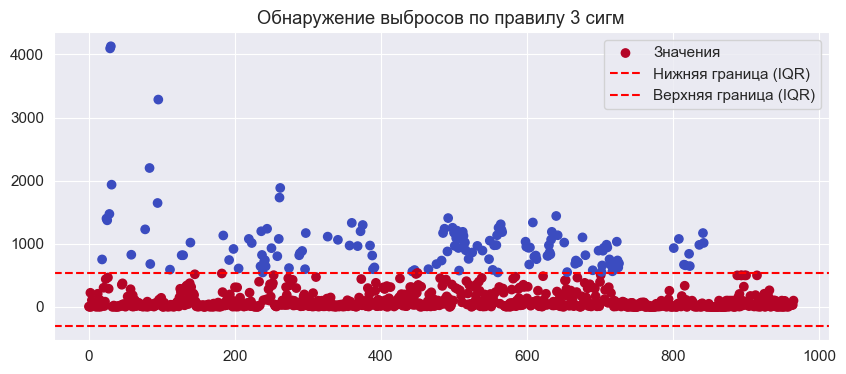

In [15]:
plt.figure(figsize=(10, 4))
plt.scatter(df.index, df[source_ic50_variable], c=~df['is_outlier_IQR'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (IQR)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (IQR)')
plt.legend()
plt.title('Обнаружение выбросов по правилу 3 сигм')
plt.show()

In [16]:
target_old = source_ic50_variable
target = "IC50_gt_median"

In [17]:
data_cleaned_IQR = df[~df['is_outlier_3σ']].drop(columns=['is_outlier_IQR', 'is_outlier_3σ', target_old])

data_cleaned_IQR

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"CC50, mM",SI,IC50_gt_median
0,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,175.482382,28.125000,0
1,-2.108224,2.095440,0.951585,-0.544168,1.254983,0.289724,-1.759553,1.260180,-2.212699,-0.571135,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,5.402819,7.000000,0
2,-2.514136,2.150839,0.957552,-1.490120,1.014426,0.745889,-1.118121,1.099403,-2.397328,-0.545366,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,161.142320,0.720000,1
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,3.075405,-0.085436,107.855654,63.235294,0
4,-1.746485,0.536885,0.783714,-0.701088,0.563542,0.902106,-1.367945,2.002451,-2.242239,-0.580930,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,139.270991,1.300000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,0.621634,-0.779389,0.307862,-0.918328,1.566453,0.492661,0.628761,-0.790557,-0.036530,-0.461498,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,34.999650,1.129017,0
962,0.834722,-0.884119,0.165598,-0.980878,1.201620,1.050498,0.704502,-0.776102,-0.233468,-0.461496,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,33.999415,1.062484,0
963,0.943127,-0.906571,0.196551,-1.377478,0.997433,1.522336,0.707042,-0.775993,0.065049,0.598260,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,33.999458,1.096761,0
964,0.893994,-0.196583,-0.286468,-0.923926,0.761096,1.340989,0.586631,-0.792770,-1.593940,-0.464683,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,32.999644,1.031272,0


In [19]:
X = data_cleaned_IQR[data_cleaned_IQR.columns[:-3]]
y_ic50 = data_cleaned_IQR[target]
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436
1,-2.108224,2.095440,0.951585,-0.544168,1.254983,0.289724,-1.759553,1.260180,-2.212699,-0.571135,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436
2,-2.514136,2.150839,0.957552,-1.490120,1.014426,0.745889,-1.118121,1.099403,-2.397328,-0.545366,...,6.369345,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,3.075405,-0.085436
4,-1.746485,0.536885,0.783714,-0.701088,0.563542,0.902106,-1.367945,2.002451,-2.242239,-0.580930,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,0.621634,-0.779389,0.307862,-0.918328,1.566453,0.492661,0.628761,-0.790557,-0.036530,-0.461498,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
962,0.834722,-0.884119,0.165598,-0.980878,1.201620,1.050498,0.704502,-0.776102,-0.233468,-0.461496,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
963,0.943127,-0.906571,0.196551,-1.377478,0.997433,1.522336,0.707042,-0.775993,0.065049,0.598260,...,-0.179657,3.613328,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
964,0.893994,-0.196583,-0.286468,-0.923926,0.761096,1.340989,0.586631,-0.792770,-1.593940,-0.464683,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436


In [22]:
X_train, X_test, y_train_ic50, y_test_ic50 = train_test_split(
    X, y_ic50, test_size=0.2, random_state=42
)

In [23]:
class_ratio = np.mean(y_train_ic50)
print(f"Баланс классов: {class_ratio:.2f} / {1-class_ratio:.2f}")

Баланс классов: 0.49 / 0.51


In [29]:
# Метрики
metrics = {
    'ROC-AUC': roc_auc_score,
    'F1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    'PRECISION': lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'),
    'RECALL': lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary')
}

# Модели и их гиперпараметры
MODELS = {
    'logreg': {
        'model': LogisticRegression(solver='liblinear', random_state=112),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    'rf': {
        'model': RandomForestClassifier(random_state=121),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'xgb': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    }
}

results = []

# Сразу ищем лучшую модель и лучшие результаты с подбором гипперпараметров
for name, config in MODELS.items():
    print(f"\nGridSearchCV для модели: {name}")

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train_ic50)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Метрики
    model_metrics = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == 'ROC-AUC':
            model_metrics[metric_name] = metric_func(y_test_ic50, y_proba)
        else:
            model_metrics[metric_name] = metric_func(y_test_ic50, y_pred)

    results.append({
        'model_name': name,
        'model': best_model,  # Сохраняем саму модель
        'best_params': grid.best_params_,
        'cv_mean_roc_auc': grid.best_score_,
        **model_metrics
    })

# Вывод результатов
results_df = pd.DataFrame(results)
results_df


GridSearchCV для модели: logreg
Fitting 5 folds for each of 8 candidates, totalling 40 fits

GridSearchCV для модели: rf
Fitting 5 folds for each of 12 candidates, totalling 60 fits

GridSearchCV для модели: xgb
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,model_name,model,best_params,cv_mean_roc_auc,ROC-AUC,F1,PRECISION,RECALL
0,logreg,"LogisticRegression(C=0.1, random_state=112, so...","{'C': 0.1, 'penalty': 'l2'}",0.763367,0.710726,0.663317,0.673469,0.653465
1,rf,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.772016,0.779813,0.691892,0.761905,0.633663
2,xgb,"XGBClassifier(base_score=None, booster=None, c...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.786036,0.772552,0.677419,0.741176,0.623762


Как видим - Random Forest и XGB классификатор показывают лучшие, примерно одинаковые результаты.